# Minimum volume ellipsoid (outlier detection)



In [1]:
%matplotlib inline

# Future 
from __future__ import print_function

# Numpy imports 
import numpy as np
import numpy.random as random

import scipy as sp
import scipy.linalg as la


# Import matplotlib.pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# My imports 
from ellipsoidal_outlier_detector import EllipsoidSolver, get_outliers, get_total_partition



EPS = sp.finfo(float).eps



# Example filtering in 3D 

In this example, a random set of point is created with a set of points that are sampled from a skewed multi-variate distribution.  Also, there are some outliers added by sampling a laplace distribution with the same mean.

In [25]:
# Generate random samples for testing the algorithm 
M = 500
d = 3
Na = int(d * (d+1) / 2.0 + d)


## Define a sample of variables
mean = np.array(d * [5.0,])
cov = sp.eye(d) + 5.0

xarray = random.multivariate_normal(mean, cov, M)
xarray[:20] = random.laplace(5, scale =10.0001, size=(20, mean.size))


## Problem size estimates
print("Print some rough problem size estimates:")
print("d = {0}\nM = {1}\nNa= {2}".format(d, M, Na), end='\n\n')
print("d**2 = {0}".format(d**2))
print("Na**2 = {0}".format(Na**2))

Print some rough problem size estimates:
d = 3
M = 500
Na= 9

d**2 = 9
Na**2 = 81


In [26]:

## Make a plot for the case where ndim is 3
def plot_xinxout_3d(xin, xout, A, b, ifig=0):
    """
    Plotting routine for the case where the number of filter 
    parameters is 3.  

    """

    
    Ainv = la.inv(A)
    
    # Make a 3D figure
    fig = plt.figure(ifig)
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(xin[:,0], xin[:,1], xin[:,2], marker='.')
    ax.scatter(xout[:,0], xout[:,1], xout[:,2], marker='o', c='r')


    ## Get points on a sphere
    thetas = sp.linspace(100*EPS, (1.0-100*EPS) * sp.pi, 20)
    phis = sp.linspace(0.0, 2*sp.pi, 20)
    TT, PP = sp.meshgrid(thetas, phis, indexing='ij')

    xx = sp.cos(PP) * sp.sin(TT)
    yy = sp.sin(PP) * sp.sin(TT)
    zz = sp.cos(TT)


    Ainv_xx = Ainv[:,0, None, None] * (xx - b[None, None, 0])
    Ainv_yy = Ainv[:,1, None, None] * (yy - b[None, None, 1])
    Ainv_zz = Ainv[:,2, None, None] * (zz - b[None, None, 2])

    xyz_ellipse = Ainv_xx + Ainv_yy + Ainv_zz
    xe = xyz_ellipse[0]
    ye = xyz_ellipse[1]
    ze = xyz_ellipse[2]


    ax.plot_wireframe(xe, ye, ze, linewidth=0.2)
    
    return fig



# First interface: get_outliers
This interface takes `xarray` and returns the arrays `zxin` and `xout`.  Also, you get the volume of the ellipse, `A`, `b`, and `avec`.  The vector `avec` can be used to speedup the next minimization by passing it as a kwarg to get_outliers. 

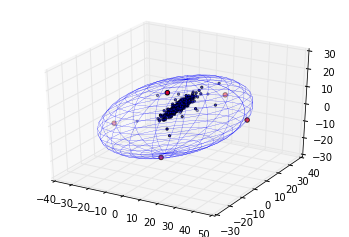

In [27]:
## Do one filter step
xin, xout, vol, A, b, avec = get_outliers(xarray, avec0=None)

## Plot the ellipse with outliers on the surface
fig = plot_xinxout_3d(xin, xout, A, b, ifig=0)


# Second interface: get_total_partition
This interface applies the `get_outliers` function until the number of samples in `xarray` is reduced by the factor `alpha`.  The output the same as `get_outliers` but now there are sequences of the output parameters for each outlier detection step.  

In [28]:
## Do a partition until the number of points is reduced to half
xin_list, xout_list, vols, As, bs = get_total_partition(xarray, alpha=0.5)

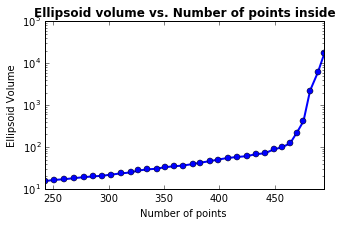

In [29]:
Ms = sp.array([xin.shape[0] for xin in xin_list])


fig = plt.figure(0, (5,3))
ax = fig.add_subplot(1,1,1)
ax.semilogy(Ms, vols, linewidth=2, marker='o')
ax.set_title("Ellipsoid volume vs. Number of points inside", 
             fontweight='bold', fontsize='large')
ax.set_ylabel("Ellipsoid Volume")
ax.set_xlabel("Number of points ")
ax.set_xbound((Ms.min(), Ms.max()))

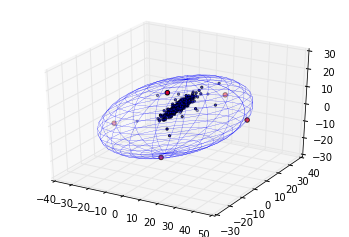

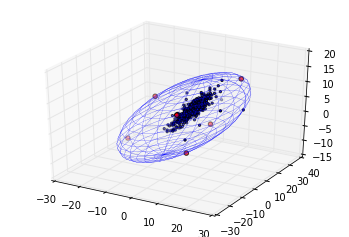

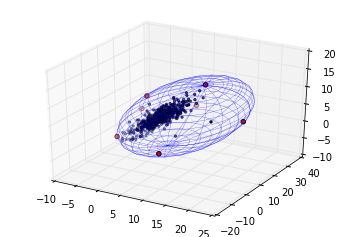

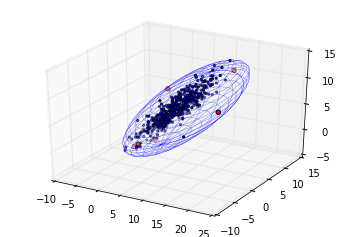

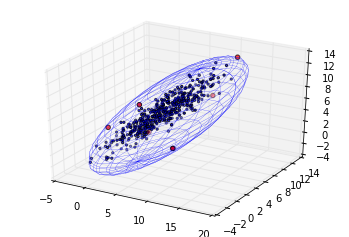

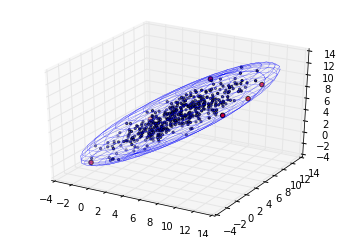

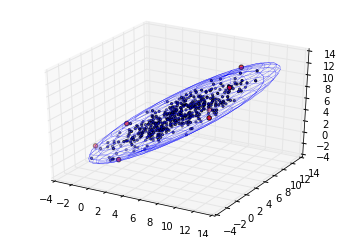

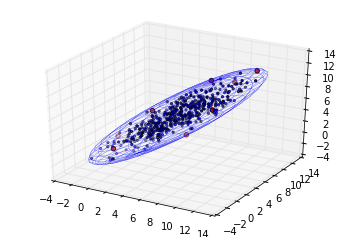

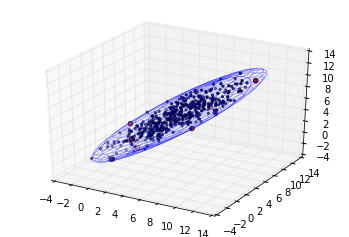

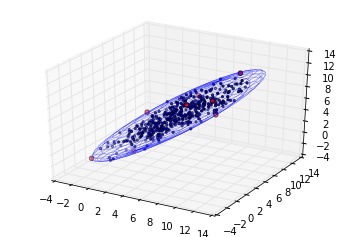

In [30]:
for ifig, xin, xout, A, b in zip(xrange(30), xin_list, xout_list, As, bs)[:10]:
    fig = plot_xinxout_3d(xin, xout, A, b, ifig=ifig)